In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import json
import pathlib
import matplotlib.patches
import matplotlib.pyplot as plt
import numpy as np

from lieroy import se3

from recov.datasets import KittiDataset, EthzDataset
from recova.clustering import CenteredClusteringAlgorithm, RegistrationPairClusteringAdapter
from recova.covariance import SamplingCovarianceComputationAlgorithm
from recova.learning.learning import model_from_file
from recova.registration_result_database import RegistrationPairDatabase

from recova.recov_plot import plot_trajectory_translation, plot_covariance
from recova.trajectory_evaluation import collect_trajectory_data, make_cumulative_covariances, trajectory_linear_length, select_sequential_pairs, make_reference_cum_cov, build_trajectory_from_dataset
from recova.util import set_matplotlibrc

np.set_printoptions(precision=6, linewidth=100)

In [ ]:
DATABASE_LOCATION = '/home/dlandry/dataset/db_kitti_02/'
LOCATION = '04'
POINTCLOUD_DATASET_LOCATION = '/home/dlandry/dataset/kitti/dataset/sequences/{}'.format(LOCATION)
LEARNING_DATASET_LOCATION = '/home/dlandry/dataset/learning_sets/2018-09-06-kitti-less-3-4-5.json'
MODEL_LOCATION = '/home/dlandry/dataset/learning_runs/2018-09-06-kitti-less-04.model'


db = RegistrationPairDatabase(DATABASE_LOCATION)
dataset = KittiDataset(pathlib.Path(POINTCLOUD_DATASET_LOCATION))

with open(LEARNING_DATASET_LOCATION) as f:
    learning_dataset = json.load(f)
    
model = model_from_file(MODEL_LOCATION, 'cello')

In [25]:
DATABASE_LOCATION = '/home/dlandry/dataset/db_eth_05/'
LOCATION = 'hauptgebaude'
POINTCLOUD_DATASET_LOCATION = '/home/dlandry/dataset/ethz/{}'.format(LOCATION)

LEARNING_DATASET_LOCATION = '/home/dlandry/dataset/learning_sets/2018-08-17-inside.json'
MODEL_LOCATION = '/home/dlandry/dataset/learning_runs/2018-08-21-hauptgebaude.model'


db = RegistrationPairDatabase(DATABASE_LOCATION)
dataset = EthzDataset(pathlib.Path(POINTCLOUD_DATASET_LOCATION))

with open(LEARNING_DATASET_LOCATION) as f:
    learning_dataset = json.load(f)
    
model = model_from_file(MODEL_LOCATION, 'cello')

In [26]:
clustering_algo = CenteredClusteringAlgorithm(radius=0.1, k=16, n_seed_init=32)
clustering_algo = RegistrationPairClusteringAdapter(clustering_algo)
cov_algo = SamplingCovarianceComputationAlgorithm(clustering_algo)

pairs = select_sequential_pairs(db, LOCATION)
gt_trajectory = build_trajectory_from_dataset(dataset)
reference_cum_cov = make_reference_cum_cov(gt_trajectory, pairs, cov_algo)


In [27]:
(gt_trajectory, 
 sampled_trajectory,
 cum_covariances, 
 censi_cum_cov) = collect_trajectory_data(db, LOCATION, dataset, learning_dataset['metadata']['descriptor_config'], model, n_sampled_trajectories=50, second_order=True)

100%|█████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 1362.55it/s]


In [28]:
length = trajectory_linear_length(gt_trajectory)
print('Length of dataset {}: {:.4}'.format(LOCATION, length))

Length of dataset hauptgebaude: 24.06


# Draft figure

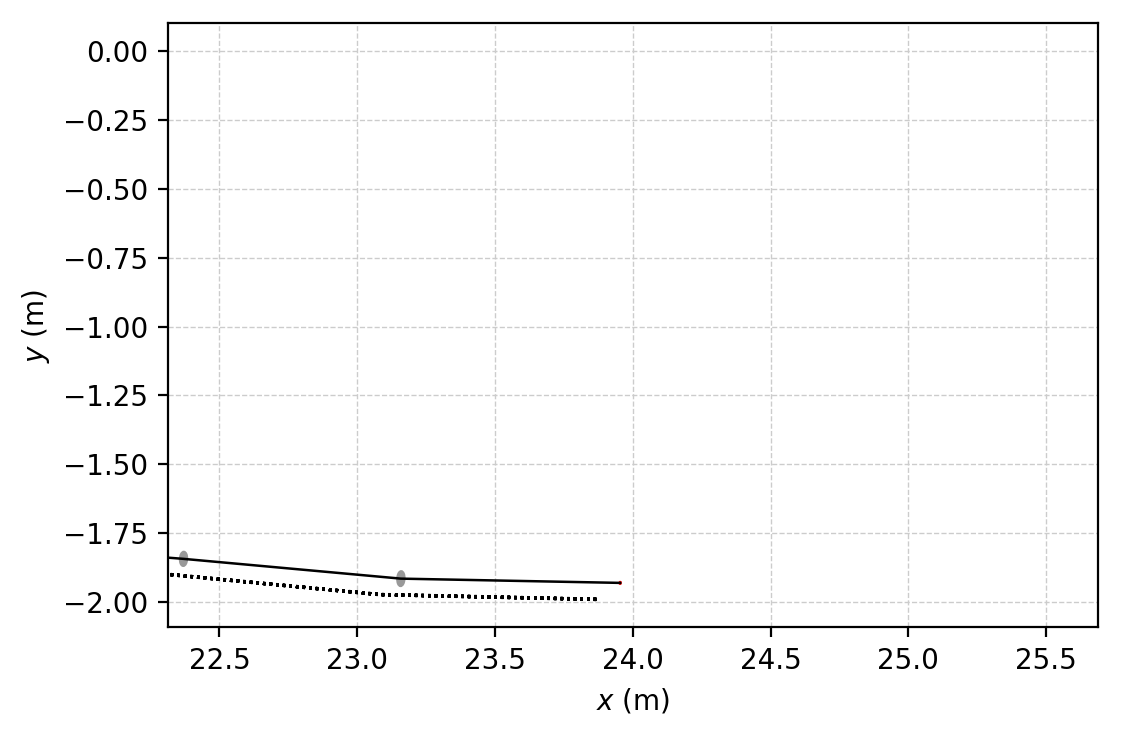

In [31]:
fig, ax = plt.subplots()
fig.set_dpi(200)

gt_handle, = plot_trajectory_translation(gt_trajectory, ax, label='GT trajectory')

for t in sampled_trajectory[:-1]:
    plot_trajectory_translation(t, ax, linestyle='dotted', color='black')    
    
#sampled_handle, = plot_trajectory_translation(t, ax, linestyle='dotted', color='black', label='Sampled\ntrajectories')

for i in range(0, len(gt_trajectory)-1, 1):
    plot_covariance(gt_trajectory[i], cum_covariances[i], ax, color='0.6', fill=True)
    
final_cov_handle = plot_covariance(gt_trajectory[-1], reference_cum_cov[-1], ax, color='red', fill=False, label='Final covariance')

    
cov_legend_handle = matplotlib.patches.Patch(color='0.6', label='Estimated\nuncertainty')
    
ax.grid(color='0.8', linewidth=0.5, zorder=-100, linestyle='--')
    
ax.set_xlabel('$x$ (m)')
ax.set_ylabel('$y$ (m)')

ax.set_xlim((23,25))
#ax.set_ylim((23,25))

#plt.legend(handles=[gt_handle, sampled_handle, cov_legend_handle, final_cov_handle])
plt.savefig('/home/dlandry/traj_trans.png')
plt.show()


# Clean figure

In [ ]:
fig, ax = plt.subplots()
fig.set_dpi(200)
fig.set_size_inches((3.413,3.413))

set_matplotlibrc()



gt_handle, = plot_trajectory_translation(gt_trajectory[:500], ax, label='GT trajectory')

for t in sampled_trajectory[:-1]:
    plot_trajectory_translation(t[0:500], ax, linestyle='dotted', color='black')    
    
sampled_handle, = plot_trajectory_translation(t[0:500], ax, linestyle='dotted', color='black', label='Sampled\ntrajectories')

for i in range(0, len(gt_trajectory[:500]), 1):
    plot_covariance(gt_trajectory[i], cum_covariances[i], ax, color='0.6', fill=True)
    
cov_legend_handle = matplotlib.patches.Patch(color='0.6', label='Estimated\nuncertainty')
    
ax.grid(color='0.8', linewidth=0.5, zorder=-100, linestyle='--')
    
ax.set_xlabel('$x$ (m)')
ax.set_ylabel('$y$ (m)')

plt.legend(handles=[gt_handle, sampled_handle, cov_legend_handle], loc='lower left')
plt.savefig('/home/dlandry/traj_trans.png')
plt.show()

In [ ]:
cum_covariances

In [ ]:
np.trace(cum_covariances)

In [ ]:
det = [np.linalg.det(x) for x in cum_covariances]

In [ ]:

det

In [ ]:
plt.plot(det)
plt.show()